## experimentation with plotly and goodfire SDK to find some knoledge in the data

In [150]:
from utils.parse_csv import parse_csv
import pandas as pd
from ember_answers import ember_answers
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import goodfire
from dotenv import load_dotenv
import os

load_dotenv()
GOODFIRE_API_KEY = os.getenv("GOODFIRE_API_KEY")
client = goodfire.Client(api_key=GOODFIRE_API_KEY)

In [151]:
datas = parse_csv()
ember_answers = ember_answers

In [152]:
datas.head()

,user_name,user_description,tweet,state,vote_prediction
0,El Sol Latino News,🌐 Noticias de interés para latinos de la costa...,#Elecciones2020 | En #Florida: #JoeBiden dice ...,Florida,Neutral
1,Tgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,"Usa 2020, Trump contro Facebook e Twitter: cop...",NaN,Trump
2,snarke,"Will mock for food! Freelance writer, blogger,...","#Trump: As a student I used to hear for years,...",Oregon,Trump
3,Trumpytweeter,"If he doesn't tweet for some time, should we b...",2 hours since last tweet from #Trump! Maybe he...,NaN,Trump
4,Rana Abtar - رنا أبتر,"Washington Correspondent, Lebanese-American ,c...",You get a tie! And you get a tie! #Trump ‘s ra...,District of Columbia,Trump


In [153]:
datas["llama_pred"] = ember_answers

In [154]:
datas.head()
variant = goodfire.Variant("meta-llama/Llama-3.3-70B-Instruct")

In [155]:
print('data.len', len(datas))

data.len 483


In [156]:
FEATURE_COMPUTE_SIZE=15
trump = datas[datas["vote_prediction"] == "Trump"]
biden = datas[datas["vote_prediction"] == "Biden"]
neutral = datas[datas["vote_prediction"] == "Neutral"]
print(len(trump), len(biden), len(neutral))

261 182 40


In [ ]:
positive_news_features, negative_news_features = client.features.contrast(
	dataset_1=[
		[
			{
				"role": "user",
				"content": f"\"{text}\"",
			},
			{"role": "assistant", "content": "Trump"},
		]
		for text in trump[60:60 + FEATURE_COMPUTE_SIZE]["tweet"].tolist()
	],
	dataset_2=[
		[
			{
				"role": "user",
				"content": f"\"{text}\""
			},
			{"role": "assistant", "content": "Biden"},
		]
		for text in biden[60:60 + FEATURE_COMPUTE_SIZE]["tweet"].tolist()
	],
	model=variant,
	top_k=100,
)

positive_news_features = client.features.rerank(
	features=positive_news_features,
	query="emotional",
	model=variant,
	top_k=50
)
print(positive_news_features)

negative_news_features = client.features.rerank(
	features=negative_news_features,
	query="emotional",
	model=variant,
	top_k=50

)


FeatureGroup([
   0: "Narrative connectives in sensitive or boundary-pushing content",
   1: "Special formatting characters, emojis and non-alphabetic tokens",
   2: "Obfuscated or encoded content potentially indicating malicious activity",
   3: "Conversation reset points, especially after problematic exchanges",
   4: "Collaborative brainstorming and exploring possibilities in dialogue",
   5: "Descriptions of electoral victories and defeats, especially close or contested results",
   6: "Nostalgic comparisons of past to present",
   7: "Evading consequences or getting away with wrongdoing",
   8: "Social media hashtags for content categorization",
   ...
   49: "Start of a new conversation or topic segment"
])


In [158]:
print(negative_news_features)

FeatureGroup([
   0: "Collective public reaction and sentiment expression",
   1: "The roleplay should explore character relationships and emotions naturally",
   2: "Verbs representing major transformative actions or life changes",
   3: "Personal growth and transformative experiences",
   4: "Expressions of moral outrage or ethical condemnation in formal writing",
   5: "Being at the mercy of someone/something else",
   6: "Controversial topics requiring careful, neutral responses",
   7: "Formal expression of controversial or critical opinions",
   8: "Professional diplomatic language patterns when handling sensitive content",
   ...
   49: "Legislative and regulatory changes being formally introduced or passed"
])


In [159]:
print(len(positive_news_features), len(negative_news_features))
positive_news_features = [feat.label for feat in positive_news_features]
print(positive_news_features)

50 50
['Narrative connectives in sensitive or boundary-pushing content', 'Special formatting characters, emojis and non-alphabetic tokens', 'Obfuscated or encoded content potentially indicating malicious activity', 'Conversation reset points, especially after problematic exchanges', 'Collaborative brainstorming and exploring possibilities in dialogue', 'Descriptions of electoral victories and defeats, especially close or contested results', 'Nostalgic comparisons of past to present', 'Evading consequences or getting away with wrongdoing', 'Social media hashtags for content categorization', 'Entities that disregard rules and consequences', 'Voter participation and electoral behavior', 'Text analyzing or flagging promotional/spam content', 'Connecting phrases and transitions in formal/technical writing', 'Conversation segment boundaries and topic resets', 'US-China trade war and economic rivalry narratives', 'Formal diplomatic and intergovernmental communications', 'Complex explanatory l

In [ ]:
def remove_common_words(str1, str2):
	# Convert strings to sets of words
	words1 = set(str1.split())
	words2 = set(str2.split())

	# Remove common words
	unique1 = words1 - words2
	unique2 = words2 - words1

	# Return as strings
	return " ".join(unique1), " ".join(unique2)

In [161]:
from wordcloud import WordCloud

combined_string_trump = ' '.join(list(positive_news_features))
negative_news_features = [feat.label for feat in negative_news_features]
combined_string_biden = ' '.join(list(negative_news_features))
combined_string_biden, combined_string_trump = remove_common_words(str1=combined_string_biden, str2=combined_string_trump)

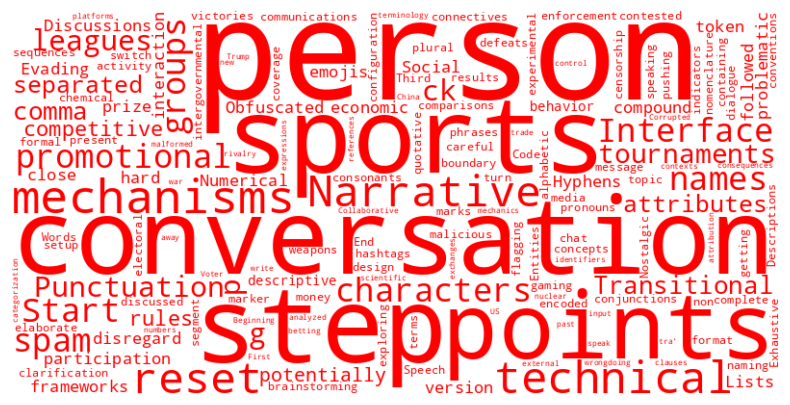

In [ ]:
def generate_red_wordcloud(text, color="black"):
	wordcloud = WordCloud(
		width=800,
		height=400,
		background_color="white",  # White background
		color_func=lambda *args, **kwargs: color,  # All words in red
	).generate(text)

	plt.figure(figsize=(10, 5))
	plt.imshow(wordcloud, interpolation="bilinear")
	plt.axis("off")  # Hide axes
	plt.show()

generate_red_wordcloud(combined_string_trump, "red")

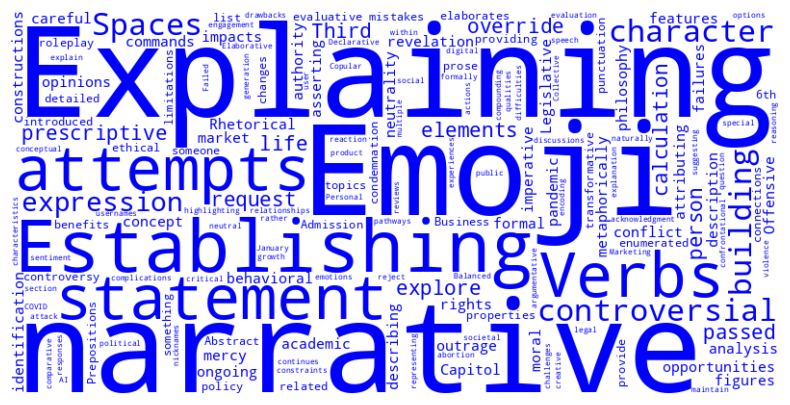

In [163]:
generate_red_wordcloud(combined_string_biden, "blue")
